# Testing a model - Random Forest 

In [247]:
%load_ext autoreload
%autoreload 2

figsize=(14, 4)

import pandas as pd
from util import util
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve
data_folder = os.path.join('..', 'data')
file_name = "DataForModel"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [248]:
data = util.load_data(data_folder, file_name)

#### Handling non numeric data

There are some columns that are non-numeric:
* Div
* Date
* HomeTeam 
* AwayTeam
* Season

In [249]:
data["Year"] = data["Date"].dt.year
data["Month"] = data["Date"].dt.month
data["Day"] = data["Date"].dt.day
data["DayOfWeek"] = data["Date"].dt.dayofweek  

data = data.drop(columns=["Date"])

One-hot encode the different teams and divisions

In [250]:
data = pd.get_dummies(data, columns=["HomeTeam", "AwayTeam"])
data_with_div = data.copy()
data = pd.get_dummies(data, columns=["Div"])

### Defining the target variable

We want to predict the outcome of a match. To create a numeric representation of this, we will create a column called Outcome which has a value 1 for home wins, 0 for draws and -1 for away wins (home loss). 

In [251]:
data["Outcome"] = data.apply(
    lambda row: (
        1 if row["FTHG"] > row["FTAG"] else (0 if row["FTHG"] == row["FTAG"] else -1)
    ),
    axis=1,
)

we remove the following columns:
* Season
* FTHG
* FTAG

We dont want FTGH and FTAG as they are the target variable. 

In [252]:
data = data.drop(columns=["FTHG", "FTAG", "Season"])

### Split data into training and testing sets

Now, we will split the data into traing and test sets to properly test our model. Football probably has evolved over the course of the 20 years, so to not get caught in only using "old" data to test predictions on "new" data, we will use a randomized sampling. 

In [253]:
X = data.copy().drop(
    columns=["Outcome"]
)  
y = data.copy()["Outcome"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Finally, we make predictions on the test set and evaluate the model.

In [254]:
y_pred = model.predict(X_test)
predicted_class_counts = pd.Series(y_pred).value_counts().sort_index()
print("Number of predictions for each class:")
print(predicted_class_counts)

print(
    "Classification Report:\n",
    classification_report(
        y_test, y_pred, target_names=["Away Win", "Draw", "Home Win"]
    ),
)

Number of predictions for each class:
-1    1908
 0     269
 1    4624
Name: count, dtype: int64
Classification Report:
               precision    recall  f1-score   support

    Away Win       0.42      0.39      0.40      2026
        Draw       0.27      0.04      0.07      1866
    Home Win       0.48      0.77      0.59      2909

    accuracy                           0.45      6801
   macro avg       0.39      0.40      0.35      6801
weighted avg       0.40      0.45      0.39      6801



##### The model gives an accuracy of 0.45.

Accuracy provides a overall summary of the model’s performance across all classes, but doesn’t tell us how well the model distinguishes between specific outcomes such as "Away Win," "Draw," and "Home Win".

We will try to include another metric to evaluate the model, namely AUC. 

#### AUC scores


Number of predictions for each class:
-1    1908
 0     269
 1    4624
Name: count, dtype: int64
Classification Report:
               precision    recall  f1-score   support

    Away Win       0.42      0.39      0.40      2026
        Draw       0.27      0.04      0.07      1866
    Home Win       0.48      0.77      0.59      2909

    accuracy                           0.45      6801
   macro avg       0.39      0.40      0.35      6801
weighted avg       0.40      0.45      0.39      6801

AUC for Away Win: 0.63
AUC for Draw: 0.52
AUC for Home Win: 0.63
AUC (macro-average): 0.59


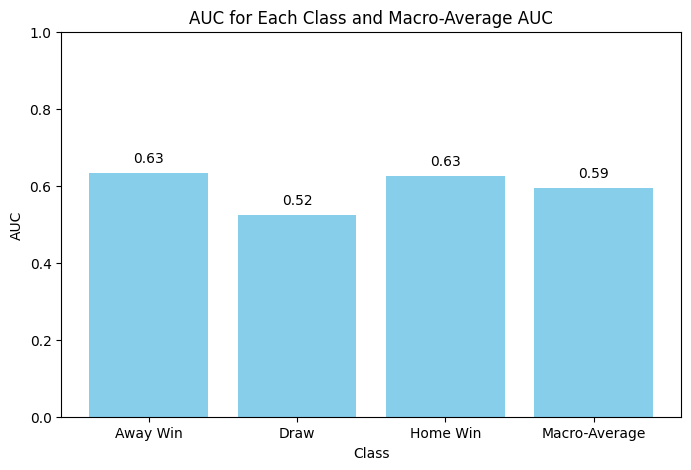

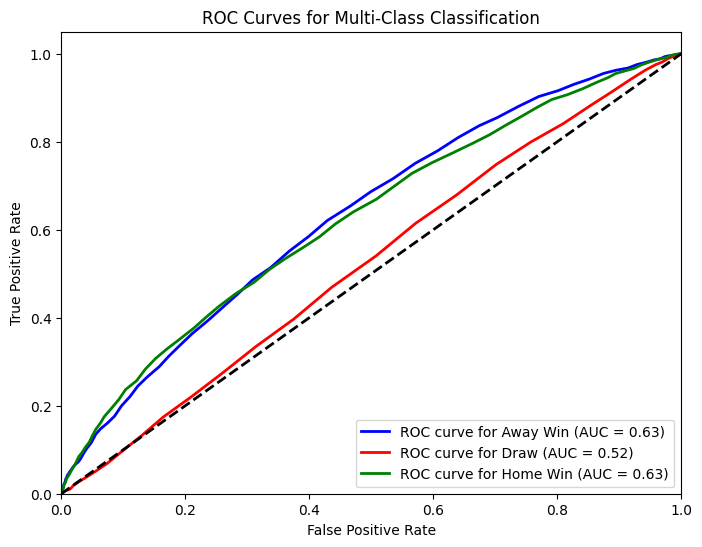

In [255]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

y_test_binarized = label_binarize(
    y_test, classes=[-1, 0, 1]
)  

auc_per_class = roc_auc_score(y_test_binarized, y_pred_proba, average=None)

auc_macro = roc_auc_score(y_test_binarized, y_pred_proba, average="macro")

predicted_class_counts = pd.Series(y_pred).value_counts().sort_index()
print("Number of predictions for each class:")
print(predicted_class_counts)

print(
    "Classification Report:\n",
    classification_report(
        y_test, y_pred, target_names=["Away Win", "Draw", "Home Win"]
    ),
)

class_names = ["Away Win", "Draw", "Home Win"]
for i, auc in enumerate(auc_per_class):
    print(f"AUC for {class_names[i]}: {auc:.2f}")

print(f"AUC (macro-average): {auc_macro:.2f}")
util.plot_auc_per_class(auc_per_class, class_names, auc_macro)
util.plot_multi_class_roc(
    y_test, y_pred_proba, classes=[-1, 0, 1], class_names=class_names
)

#### Modifying the Dataset
Up to this point, we have used data from four different leagues in our dataset. However, it may be difficult to predict the outcome of a match in one league based on data from another league. Additionally, there are differences between leagues; for example, in the Premier League, teams are expected to be more stable over time. We will now try using only data from the English Premier League to see if this improves the model.

The best teams doest go down

In [256]:
# Get the dataset but only for PL
data_premier_leauge = data_with_div[data_with_div["Div"] == "E0"]
data_premier_leauge

,Div,FTHG,FTAG,Season,ELO diff,Home_prob_ELO,Draw_prob_ELO,Away_prob_ELO,Diff_goals_scored,Diff_goals_conceded,...,AwayTeam_Walsall,AwayTeam_Watford,AwayTeam_West Brom,AwayTeam_West Ham,AwayTeam_Wigan,AwayTeam_Wolves,AwayTeam_Wrexham,AwayTeam_Wycombe,AwayTeam_Yeovil,AwayTeam_York
0,E0,1.0,1.0,0506,-25.173204,0.412832,0.245673,0.341496,0,6,...,False,False,False,False,False,False,False,False,False,False
1,E0,1.0,1.0,0506,6.045620,0.468846,0.222236,0.308918,0,-1,...,False,False,False,False,False,False,False,False,False,False
2,E0,1.0,1.0,0506,-32.751187,0.399092,0.251422,0.349487,-3,-1,...,False,False,True,False,False,False,False,False,False,False
3,E0,0.0,3.0,0506,34.014412,0.517707,0.201792,0.280500,2,-2,...,False,False,False,False,False,False,False,False,False,False
4,E0,0.0,1.0,0506,33.333649,0.516538,0.202282,0.281180,1,0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32523,E0,5.0,0.0,2324,-90.969466,0.324565,0.233493,0.441941,5,-3,...,False,False,False,False,False,False,False,False,False,False
32524,E0,2.0,0.0,2324,243.886381,0.803305,0.082298,0.114397,8,-2,...,False,False,False,False,False,True,False,False,False,False
32525,E0,2.0,4.0,2324,-127.316525,0.287220,0.206627,0.506153,1,8,...,False,False,False,False,False,False,False,False,False,False
32526,E0,3.0,1.0,2324,315.526105,0.862550,0.057509,0.079941,10,-14,...,False,False,False,True,False,False,False,False,False,False


In [257]:


data_premier_leauge.drop(columns="Div", inplace=True)

data_premier_leauge["Outcome"] = data_premier_leauge.apply(
    lambda row: (
        1 if row["FTHG"] > row["FTAG"] else (0 if row["FTHG"] == row["FTAG"] else -1)
    ),
    axis=1,
)

data_premier_leauge.to_csv("../data/DataPLForModel.csv", index=False)

/var/folders/91/krf3259915q7p7c3dwrtcbg80000gn/T/ipykernel_23110/1025997646.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_premier_leauge.drop(columns="Div", inplace=True)
/var/folders/91/krf3259915q7p7c3dwrtcbg80000gn/T/ipykernel_23110/1025997646.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_premier_leauge["Outcome"] = data_premier_leauge.apply(


In [258]:
X = data_premier_leauge.copy().drop(
    columns=["Outcome", "FTHG", "FTAG", "Season"]
)  
y = data_premier_leauge.copy()["Outcome"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

A look at the new results:

Number of predictions for each class:
-1    389
 0     54
 1    808
Name: count, dtype: int64
Classification Report:
               precision    recall  f1-score   support

    Away Win       0.52      0.55      0.54       368
        Draw       0.35      0.07      0.12       268
    Home Win       0.61      0.80      0.69       615

    accuracy                           0.57      1251
   macro avg       0.50      0.48      0.45      1251
weighted avg       0.53      0.57      0.52      1251

AUC for Away Win: 0.75
AUC for Draw: 0.59
AUC for Home Win: 0.74
AUC (macro-average): 0.69


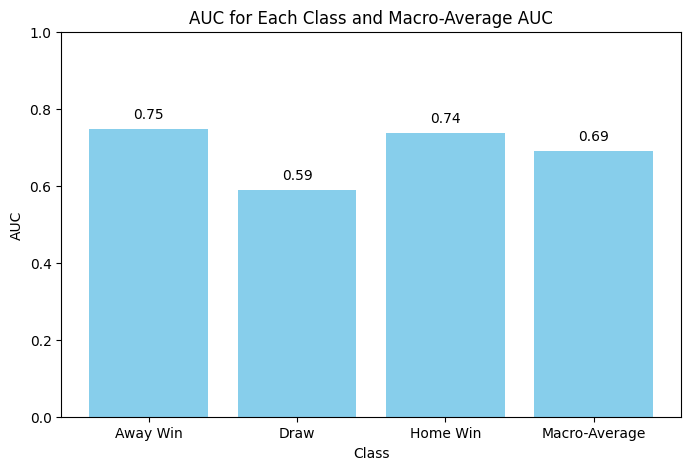

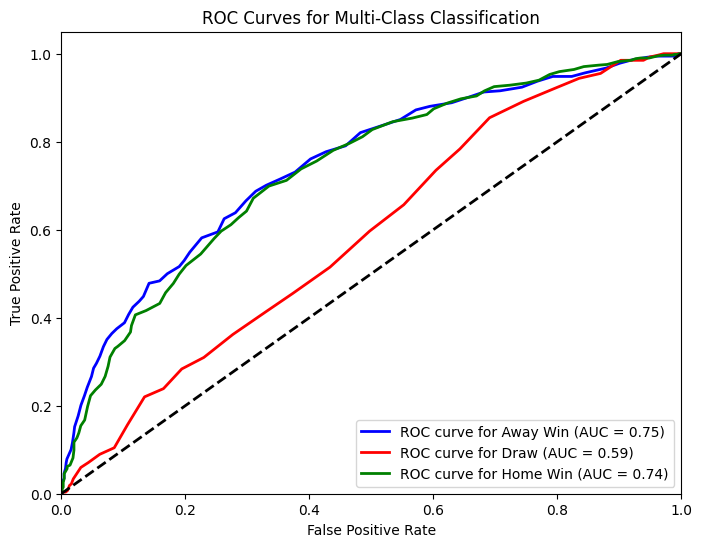

In [259]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

y_test_binarized = label_binarize(
    y_test, classes=[-1, 0, 1]
)  

auc_per_class = roc_auc_score(y_test_binarized, y_pred_proba, average=None)

auc_macro = roc_auc_score(y_test_binarized, y_pred_proba, average="macro")

classification_report_no_thr = classification_report(
    y_test, y_pred, target_names=["Away Win", "Draw", "Home Win"]
)

predicted_class_counts = pd.Series(y_pred).value_counts().sort_index()
print("Number of predictions for each class:")
print(predicted_class_counts)

print(
    "Classification Report:\n",
    classification_report_no_thr,
)

class_names = ["Away Win", "Draw", "Home Win"]
for i, auc in enumerate(auc_per_class):
    print(f"AUC for {class_names[i]}: {auc:.2f}")

print(f"AUC (macro-average): {auc_macro:.2f}")
util.plot_auc_per_class(auc_per_class, class_names, auc_macro)
util.plot_multi_class_roc(
    y_test, y_pred_proba, classes=[-1, 0, 1], class_names=class_names
)

This is an improvement on the AUC scores. Away win is 0.75, Draw is 0.59 and Home Win is 0.74. The macro average AUC is 0.69.

#### Using Joudens J statistic
We want to identify thresholds that capture as many true positives (correct predictions of the outcome) as possible without producing too many false positives (incorrect predictions of the outcome). Youden’s J statistic maximizes the difference between the True Positive Rate and False Positive Rate, finding a threshold where the model is good at identifying true cases while minimizing incorrect positive predictions.


We will now calculate the Youden’s J statistic for each class and use it to find the optimal threshold for each class. We will then use these thresholds to make predictions on the test set and evaluate the model.

In [260]:
away_win_threshold = util.find_optimal_threshold(y_test_binarized[:, 0], y_pred_proba[:, 0], "away win") 
draw_threshold = util.find_optimal_threshold(y_test_binarized[:, 1], y_pred_proba[:, 1], "draw") 
home_win_threshold = util.find_optimal_threshold(y_test_binarized[:, 2], y_pred_proba[:, 2], "hom win")



optimal stats for away win:
Optimal Threshold: 0.31

optimal stats for draw:
Optimal Threshold: 0.21

optimal stats for hom win:
Optimal Threshold: 0.44



#### Applying the thresholds to make predictions
* Get the highest probability for a match outcome
* If the probability is higher than the threshold for that class, predict that class
* If the probability is lower than the threshold for that class, dont predict anything for the match

In [261]:
thresholds = {-1: away_win_threshold, 0: draw_threshold, 1: home_win_threshold}
predictions = util.make_thresholded_predictions(y_pred_proba, thresholds)

count = 0
for i in range(len(predictions)):
    if predictions[i] == None:
        count += 1

print(f"Procentage of predictions that were skipped: {count/len(predictions)*100:.2f}%")
y_test = y_test.tolist() if isinstance(y_test, pd.Series) else y_test


valid_indices = [i for i, pred in enumerate(predictions) if pred is not None]
filtered_predictions = [predictions[i] for i in valid_indices]
filtered_y_test = [y_test[i] for i in valid_indices]


accuracy = accuracy_score(filtered_y_test, filtered_predictions)

print("Classification Report (without thresholds):\n", classification_report_no_thr)


print(
    "Classification Report (with thresholds):\n",
    classification_report(
        filtered_y_test, filtered_predictions, target_names=class_names
    ),
)

Procentage of predictions that were skipped: 15.83%
Classification Report (without thresholds):
               precision    recall  f1-score   support

    Away Win       0.52      0.55      0.54       368
        Draw       0.35      0.07      0.12       268
    Home Win       0.61      0.80      0.69       615

    accuracy                           0.57      1251
   macro avg       0.50      0.48      0.45      1251
weighted avg       0.53      0.57      0.52      1251

Classification Report (with thresholds):
               precision    recall  f1-score   support

    Away Win       0.52      0.66      0.58       309
        Draw       0.35      0.09      0.14       209
    Home Win       0.68      0.77      0.72       535

    accuracy                           0.60      1053
   macro avg       0.52      0.51      0.48      1053
weighted avg       0.57      0.60      0.57      1053

